In [107]:
import pandas as pd
import numpy as np
from copy import copy, deepcopy
import random
import datetime

In [ ]:
# Import data
seed = 44
np.random.seed(seed)
random.seed(seed)

print("Reading file...")
all_df = pd.read_csv('./data.csv', low_memory=False)
print("Done reading!")
all_df['time'] = pd.to_datetime(all_df['timestamp'] * 1000000000)
all_df = all_df.rename({'time': 'ds', 'percentOfMaxPrice': 'y'}, axis='columns')
dfs = [v for k, v in all_df.groupby('itadPlain')]
print("Everything done!")

In [2]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

onlyTrend = []
for df in dfs:
    onlyTrend.append(df['y'])

trends = np.array(onlyTrend, dtype=object)

/usr/local/lib/python3.8/dist-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# Convert it so that it's compatible with numpy
for i in range(0, len(trends)):
    trends[i] = trends[i].to_numpy()

# Intro

In this notebook, we are going to focus on the supervised learning models. Namely, linear regression of booleans, and the basic Markov Chain, and predicting based on trends (after classification).




In [4]:
# Standardize the length, then normalize around 0
# X_train = TimeSeriesResampler(sz=80).fit_transform(trends)[:2000]
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train = trends
np.random.shuffle(X_train)
X_train = X_train[:2000]

In [98]:
# Let's get started with the linear regression of booleans
# In this case, we need to make our own records, except we have to pick them from different observations in the given data
# We use a method, so that it's flexible, and we can compare its effectiveness if we do {classify and split before regression}, or {we don't.}
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


def lin_reg_model_train(data,samples_per_game=10,num_prev_states=5,num_future_states=30,train_perc=0.8,model=GaussianNB(),verbose=False):
    """
    Trains and returns a linear classifier.

    :param model: Sklearn-compatible model to train
    :param callback: Code to run at the end to evaluate performance.
    :param train_perc: % of data dedicated to training
    :param num_future_states: number of days to look in the future
    :param num_prev_states: number of days to consider (in the past)
    :param data: data to train on.
    :param samples_per_game: Expected number of samples per game taken. (actual number may be higher or lower).
    :return: trained model
    """
    data_sz = len(data)
    num_samples = data_sz * samples_per_game

    observations = np.zeros((num_samples, num_prev_states + num_future_states), dtype=float)
    selected_games = np.random.randint(data_sz, size=num_samples)
    sample_len = num_prev_states + num_future_states
    for ind, game_ind in enumerate(selected_games):
        # Impossible to take a sample from a game that isn't long enough
        if len(data[game_ind]) < sample_len:
            # This creates an empty row. Make sure to filter it out later on.
            continue
        start_ind = random.randint(0, len(data[game_ind]) - sample_len)
        observations[ind] = copy(data[game_ind][start_ind:start_ind + sample_len])


    info = observations[~np.all(observations == 0, axis=1)]

    # Label the data
    X_raw, y_raw = info[:,:num_prev_states], info[:,num_prev_states:]


    # Create arr that defaults to false
    X =  np.full((len(info), 11), 0)
    y = np.full((len(info), 11), False)

    # Categorize into buckets of:
    # [0, 0.1)
    # [0.1, 0.2)
    # etc.
    # We set it to true if it's present
    dividers = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1]

    # Bin data to show if a given row contains a price in that bin.
    for ind, row in enumerate(X_raw):
        hist, _ = np.histogram(row, dividers)
        for hist_ind in range(0, len(hist)):
            X[ind, hist_ind] = hist[hist_ind]

    # Do the same for the test data
    for ind, row in enumerate(y_raw):
        hist, _ = np.histogram(row, dividers)
        for hist_ind in range(0, len(hist)):
            if hist[hist_ind]:
                y[ind, hist_ind] = True

    X_train, X_test, y_train, y_test =train_test_split(X,y,test_size= 1-train_perc, random_state=0)

    # importing standard scaler
    from sklearn.preprocessing import StandardScaler

    # scaling the input data
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)

    # Train a model per prediction
    accuracy_results = []
    for i in range (0, 11):
        target = y_train[:,i]
        # training the model
        model.fit(X_train, target)

        # testing the model
        y_pred = model.predict(X_test)

        # import scikit-learn metrics module for accuracy calculation
        from sklearn import metrics
        # printing accuracy
        accuracy =  metrics.accuracy_score(y_test[:,i], y_pred)
        accuracy_results.append(accuracy)
    if verbose:
        print(f"Accuracy: {np.round(accuracy_results, 2)}")
        print(f"Mean: {np.round(np.mean(accuracy_results),4)}\tStd: {np.round(np.std(accuracy_results),4)}")

    return model, accuracy_results

_ = lin_reg_model_train(X_train, samples_per_game=1)


In [99]:
# import Gaussian Naive Bayes model


# create a Gaussian Classifier
gaus = GaussianNB()

# Experiment
# Seeing how more samples affect it
# Hypothesis: Currently, with 1 sample per game, the accuracy hovers at around 70-80%. By 100x the samples per game up to 100, I expect the accuracy to similarly improve up to sqrt(0.7) to sqrt(0.75). Evauluated, the accuracy is ~0.83-0.86
# Result: The 100 games performs roughly as well as the 1 sample per game, while also taking a fraction of the time to make. Do not use.
lin_reg_model_train(X_train, samples_per_game=1, model=gaus, verbose=True)
lin_reg_model_train(X_train, samples_per_game=100, model=gaus, verbose=True)

Accuracy: [0.92 0.66 0.66 0.82 0.69 0.92 0.91 0.81 0.84 0.92 0.12]
Mean: 0.7507	Std: 0.2221
Accuracy: [0.96 0.69 0.77 0.88 0.86 0.92 0.92 0.8  0.85 0.97 0.98]
Mean: 0.8717	Std: 0.0864


(GaussianNB(),
 [0.9564025651634257,
  0.6907581712867191,
  0.7654375258585022,
  0.8810508895324782,
  0.8633636739760033,
  0.916037443111295,
  0.921183285064129,
  0.7962350020686801,
  0.8538477451386016,
  0.9687112122465866,
  0.9760033098882913])

In [100]:
# Experiment
# Maybe that went too far? Let's try just doing 10x
# Hypothesis: This will do nothing
# Result: The 10 sample consistently outperforms the 1 sample by ~4%. Maybe there is a sweet spot somewhere in between 10-100? 10 sample also has way less variance.
one_accuracy = []
ten_accuracy = []
for i in range(0, 10):
    _, a = lin_reg_model_train(X_train, samples_per_game=1, model=gaus)
    one_accuracy.append(np.mean(a))
    _, b = lin_reg_model_train(X_train, samples_per_game=10, model=gaus)
    ten_accuracy.append(np.mean(b))

print(f"One accuracy mean: {np.mean(one_accuracy)}, {np.round(one_accuracy, 2)}")
print(f"Ten accuracy mean: {np.mean(ten_accuracy)}, {np.round(ten_accuracy, 2)}")

One accuracy mean: 0.8434172397785001, [0.83 0.85 0.82 0.86 0.86 0.87 0.86 0.84 0.77 0.87]
Ten accuracy mean: 0.8715249365642341, [0.87 0.88 0.87 0.87 0.87 0.87 0.88 0.87 0.87 0.87]


In [131]:
def gaus_mean_mean(samples_per_game=10):
    accuracy = []
    std = []
    for i in range(0, 15):
        _, a = lin_reg_model_train(X_train, samples_per_game=1, model=gaus)
        accuracy.append(np.mean(a))
        std.append(np.std(a))
    return np.mean(accuracy), np.mean(std)

df = pd.DataFrame({
     'x' : range(1, 102 ,5),
    'mean': np.zeros(21),
    'std': np.zeros(21),
})


for ind, row in df.iterrows():
    a, b = gaus_mean_mean(row['x'])
    df.loc[ind, 'mean'] = a
    df.loc[ind, 'std'] = b

df


,x,mean,std
0,1,0.848926,0.086688
1,6,0.849437,0.086478
2,11,0.843791,0.098602
3,16,0.851032,0.089033
4,21,0.854106,0.076317
5,26,0.849848,0.088337
6,31,0.846256,0.088871
7,36,0.853615,0.078232
8,41,0.846899,0.091841
9,46,0.841775,0.093674


<AxesSubplot:title={'center':'Number of samples per game vs Mean Accuracy'}, xlabel='x'>

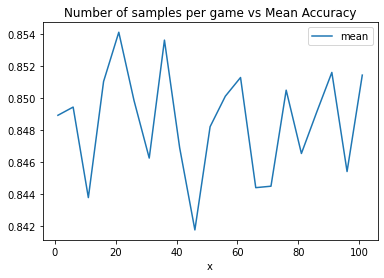

In [132]:
df.plot('x', 'mean', title="Number of samples per game vs Mean Accuracy")

<AxesSubplot:title={'center':'Number of samples per game vs Std Dev of Accuracy'}, xlabel='x'>

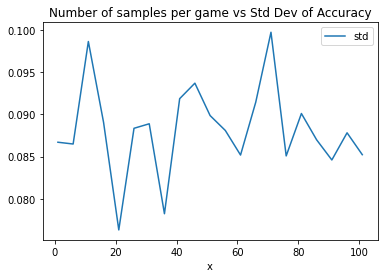

In [133]:
df.plot('x', 'std', title="Number of samples per game vs Std Dev of Accuracy")

Looking at these two graphs, it's pretty obvious that x=20 and x=35 are the best values, as they have the highest accuracy, and the lowest standard deviation, with x=20 being better than x=35 in both respects.
We will choose x=20 because 1) it's the best option and 2) it's lower than 35 so it has performance benefits as well.

In [123]:




for row in df:
    print(row)

x
mean
std
